# UFC_Stats Web Scraping

## importing pertinent libraries

In [1]:
#importing pertinent libraries
import pandas as pd
#from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests, re
import json
import itertools
from datetime import datetime
import pickle
import numpy as np

In [2]:
#creating datetime object to parse out future events
today = datetime.today()
current_date= today.strftime("%B %d, %Y")
current_datetime = datetime.strptime(current_date, "%B %d, %Y") 

The datetime data will be used to prevent data from being included for events that have not occured yet.

## Fetching Fighter Url List

Run fighter_url_fetcher.py script to populate base fighter_url_list. Database can be updated by running the data base updater afterwords.

In [50]:
with open('fighter_url_list', 'rb') as f:
    fighter_url_list = pickle.load(f)

## Creating Dataframe Building Blocks

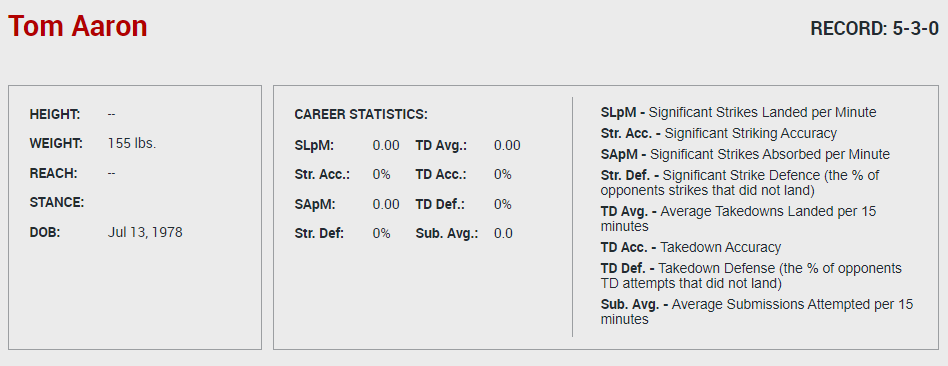

The above information cannont be parsed by pd.read_html() due to the data being outside of a table class. This information is critical to building fighter profiles for the database and will need to be parsed. Each box in fighter profile will be converted to a dataframe for later upload to SQLite database.

### Creating soup related functions Generating BS4 object lists

In [3]:
def soup_generator(url):
    
    '''Meant to parse any url entered via beuatiful soup
    Args:
        url(str): url that will be parsed using BeautifulSoup'''
    
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    return soup

In [52]:
#creating a soup list to reduce number of website requests
fighter_url_soup_list = list(map(soup_generator, fighter_url_list))

Now that fighter websites have been parsed into soups, we can isolate information based on classes obtained in the inspector view of their respective web pages. 

In [4]:
def generate_basic_stats_soup(soup):
    
    '''Initializes soup object that extracts fighter physical attributes.
    Args:
        soup(BeautifulSoup object) : must be an unaltered soup generated via soup_generator()'''
    
    base_stats = soup.findChildren('li', attrs={'class': re.compile('b-list')})
    
    return base_stats

In [54]:
fighter_stats_objects = list(map(generate_basic_stats_soup, fighter_url_soup_list))

The objects generated by fighter_stats_objects will be parsed through a series of functions to extract desired info later.

### Construction of Fighter Physical Statistics DataFrame 

In [55]:
import phys_stat_df_constructor as phystats

To keep this notebook cleaner, functions necessary for websrapping were developed vi python script and importing.

In [56]:
#generating lists of data necessary for creating the final dataframe

fighter_names = list(map(phystats.fighter_name, fighter_url_soup_list))
fighter_records = list(map(phystats.fighter_record, fighter_url_soup_list))
fighter_heights =  list(map(phystats.basic_stats_height, fighter_stats_objects))
fighter_weights = list(map(phystats.basic_stats_weight, fighter_stats_objects))
fighter_reachs = list(map(phystats.basic_stats_reach, fighter_stats_objects))
fighter_stances = list(map(phystats.basic_stats_stance, fighter_stats_objects))
fighter_DOBs = list(map(phystats.basic_stats_DOB, fighter_stats_objects))

In [57]:
#generating empty dataframe for appending

fighter_physical_stats_df = pd.DataFrame()

#generating the columns for the final df

fighter_physical_stats_df['name'] = fighter_names
fighter_physical_stats_df['record'] = fighter_records
fighter_physical_stats_df['height'] = fighter_heights
fighter_physical_stats_df['weight'] = fighter_weights
fighter_physical_stats_df['reach'] = fighter_reachs
fighter_physical_stats_df['stance'] = fighter_stances
fighter_physical_stats_df['DOB'] = fighter_DOBs

In [58]:
fighter_physical_stats_df.head()

,name,record,height,weight,reach,stance,DOB
0,Felipe Arantes,18-10-1 (2 NC),68.0,135.0,73.0,Orthodox,"Feb 09, 1988"
1,Marcus Aurelio,22-10-0,70.0,155.0,74.0,Orthodox,"Aug 18, 1973"
2,Aleksandra Albu,3-2-0,62.0,115.0,63.0,Orthodox,"Jul 14, 1990"
3,Makwan Amirkhani,16-4-0,70.0,145.0,72.0,Southpaw,"Nov 08, 1988"
4,Sam Adkins,7-20-2,75.0,225.0,NaN,Orthodox,"Apr 26, 1965"


The record column should be split into multiple columns denoting wins, losses, draws, and no contest outcomes. This will making subsequent queries easier to run.

In [59]:
#saving raw data from scrapping.
fighter_physical_stats_df.to_csv('raw_fighter_physical_stats_csv', index=False)

### Converting fighter_physcial_stats_df['record'] into wins, loses, draws, no-contest columns

In [60]:
#isolating records column for easier manipulation

records = fighter_physical_stats_df.record
records.head()

0    18-10-1 (2 NC)
1           22-10-0
2             3-2-0
3            16-4-0
4            7-20-2
Name: record, dtype: object

As previously stated, each object in the recrods column is a string that should be parsed into digits to ensure easy query generation. 

In [61]:
#creating lists used to append fighter_physical_stats_df

wins = []
losses = []
draws = []
ncs = []

for record in records:
    
    #identifying records that include no-contest outcomes
    if 'NC' in record:
        
        #split string into a list of str items 
        w_l_d_nc_record = record.split(' ')
        
        #isolating no-contest instances from the rest the record
        nc = w_l_d_nc_record[1].strip('(')
        
        #adding win-count to wins list
        wins.append(w_l_d_nc_record[0].split('-')[0])
         
        #adding lose-count to wins list
        losses.append(w_l_d_nc_record[0].split('-')[1])
        
        #adding draw-count to wins list
        draws.append(w_l_d_nc_record[0].split('-')[2])
        
        #adding no-contest count to ncs list
        ncs.append(nc)
        
    #catches all values without no-contest outcomes
    else:
        
        w_l_d_record = record.split('-')
        
        #adding win-count to wins list
        wins.append(w_l_d_record[0])
        
        #adding lose-count to wins list
        losses.append(w_l_d_record[1])
        
        #adding lose-count to wins list
        draws.append(w_l_d_record[2])
        
        #adding draw-count to wins list
        ncs.append(0)


In [62]:
#assigning newly generated lists to fighter_phsyical_stats_df

fighter_physical_stats_df['wins'] = wins
fighter_physical_stats_df['losses'] = losses
fighter_physical_stats_df['draws'] = draws
fighter_physical_stats_df['no_constests'] = ncs

In [63]:
#Dropping redundant columns and reordering existing columns
fighter_physical_stats_df = fighter_physical_stats_df[['name', 'wins','losses', 'draws', 'no_constests', 'height', 
                                                       'weight', 'reach', 'stance', 'DOB']]

fighter_physical_stats_df.head()

,name,wins,losses,draws,no_constests,height,weight,reach,stance,DOB
0,Felipe Arantes,18,10,1,2,68.0,135.0,73.0,Orthodox,"Feb 09, 1988"
1,Marcus Aurelio,22,10,0,0,70.0,155.0,74.0,Orthodox,"Aug 18, 1973"
2,Aleksandra Albu,3,2,0,0,62.0,115.0,63.0,Orthodox,"Jul 14, 1990"
3,Makwan Amirkhani,16,4,0,0,70.0,145.0,72.0,Southpaw,"Nov 08, 1988"
4,Sam Adkins,7,20,2,0,75.0,225.0,NaN,Orthodox,"Apr 26, 1965"


In [64]:
fighter_physical_stats_df.to_csv('fighter_physical_stats_csv', columns=list(fighter_physical_stats_df.columns), index=False)

### Construction of Career Statistics DataFrame 

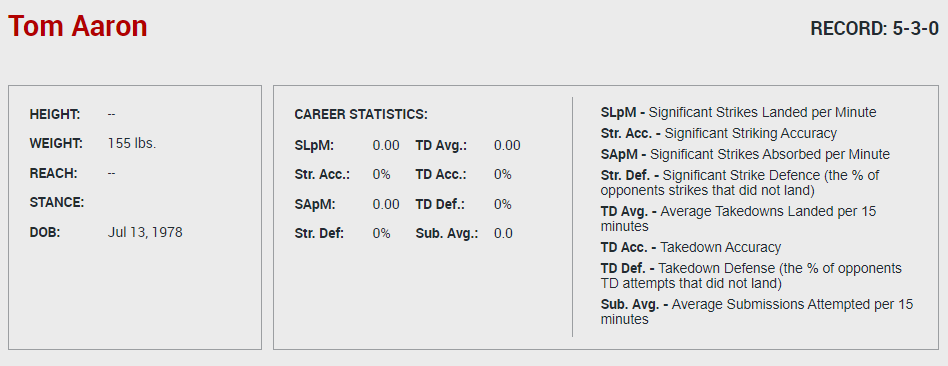

Now we need to isolate career stats for each fighter. A series of functions fimilar to those generated above will need to be constructed.

In [65]:
#importing functions needed for scrapping career statistics

import career_stats_df_constructor as cstats

In [66]:
#generating variable columns via mapping

fighter_SLpMs = list(map(cstats.SLpM, fighter_stats_objects))
fighter_StrAccs = list(map(cstats.StrAcc, fighter_stats_objects))
fighter_SApMs = list(map(cstats.SApM, fighter_stats_objects))
fighter_StrDefs =list(map(cstats.StrDef, fighter_stats_objects))
fighter_TDAvgs = list(map(cstats.TDAvg, fighter_stats_objects))
fighter_TDAccs = list(map(cstats.TDAcc, fighter_stats_objects))
fighter_TDDefs = list(map(cstats.TDDef, fighter_stats_objects))
fighter_SubAvgs = list(map(cstats.SubAvg, fighter_stats_objects))

In [67]:
#generating final data frame
fighter_career_stats_df = pd.DataFrame()

fighter_career_stats_df['name'] = fighter_names

fighter_career_stats_df['SLpMs'] = fighter_SLpMs

fighter_career_stats_df['StrAccs'] = fighter_StrAccs

fighter_career_stats_df['SApMs'] = fighter_SApMs

fighter_career_stats_df['StrDefs'] = fighter_StrDefs

fighter_career_stats_df['TDAvgs'] = fighter_TDAvgs

fighter_career_stats_df['TDAccs'] = fighter_TDAccs

fighter_career_stats_df['TDDefs'] = fighter_TDDefs

fighter_career_stats_df['SubAvgs'] = fighter_SubAvgs

In [68]:
fighter_career_stats_df.head()

,name,SLpMs,StrAccs,SApMs,StrDefs,TDAvgs,TDAccs,TDDefs,SubAvgs
0,Felipe Arantes,2.37,45.0,2.66,64.0,0.93,47.0,41.0,0.7
1,Marcus Aurelio,1.42,33.0,2.27,59.0,1.69,27.0,27.0,1.3
2,Aleksandra Albu,4.83,47.0,5.56,38.0,2.27,50.0,77.0,0.4
3,Makwan Amirkhani,1.55,46.0,2.73,50.0,3.45,36.0,57.0,1.6
4,Sam Adkins,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0


In [69]:
fighter_career_stats_df.to_csv('fighter_career_stats_csv', index=False)

### Constructing Fight Event and Fight List Database

Run event_url_fetcher.py script to populate base fighter_url_list. Database can be updated by running the data base updater afterwords.

In [75]:
#retrieving event_url_list
with open('event_url_list', 'rb') as f:
    event_url_list = pickle.load(f)

#### Event Database Populator

In [76]:
def event_fight_participants_fetcher(event_soup):
    
    '''Initializes a list object that isolates fight participant pairs in an event_soup.
    Args: 
        event_soup: object initialized via soup_generator(). Must target a UFC event url.'''
    
    fight_pairs = []
    
    name_holder = event_soup.findChildren('a', attrs={'class': re.compile('b-link')})
    
    fighter1_list_holder, fighter2_list_holder = name_holder[0::2], name_holder[1::2]
    
    fighter1_list = []
    fighter2_list = []

    for fighter1 in fighter1_list_holder:
        fighter1_list.append(fighter1.text.strip())

    for fighter2 in fighter2_list_holder:       
        fighter2_list.append(fighter2.text.strip())
        
    return [x for y in zip(fighter1_list, fighter2_list) for x in y]

In [77]:
def column_transformer(df, column):
    
    '''This function reformats any df[column] with 2 item sublists in individual integers  
    Args: 
        df:  dataframes specific to UFC event pages gathered via pd.read_html()[1]
        column: target columne intended  to be transformed into value pairs '''
    
    value_pairs = []
    
    for x in range(0, len(df.index)):
        
        values_split = df.iloc[x][column].split()
        values_split = [(value).strip() for value in values_split] 
        value_pairs.append(values_split)
        
    df[column] = value_pairs

In [78]:
def event_name_fetcher(event_soup):
    
    '''Initializes a list object that isolates fight participant pairs in an event_soup.
    Args: 
        event_soup: object initialized via soup_generator(). Must target a UFC event url.'''
    
    event_title = event_soup.find('h2', attrs={'class': re.compile('b-content__')}).text.strip()
    
    return event_title

In [79]:
def event_date_fetcher(event_soup):
    
    '''Initializes a list object that isolates fight participant pairs in an event_soup.
    Args: 
        event_soup: object initialized via soup_generator(). Must target a UFC event url.'''
    
    date_holder = event_soup.findChildren('li', attrs={'class': re.compile('b-list__')})
    
    try:
        date = date_holder[0].text.split(':')[1].strip()
        return date 
        
    except:
        pass    

In [80]:
def unnesting(df, explode):
    
    '''Initializes a list object that isolates fight participant pairs in an event_soup.
    Args: 
        event_soup: object initialized via soup_generator(). Must target a UFC event url.'''
    
    idx = df.index.repeat(df[explode[0]].str.len())
    df1 = pd.concat([pd.DataFrame({x: np.concatenate(df[x].values)}) for x in explode], axis=1)
    df1.index = idx
    
    return df1.join(df.drop(explode, 1), how='left')

In [ ]:
#identifying columngs that must be transformed
target_columns = ['Str', 'Td', 'Sub', 'Pass']

#final dataframe
transformed_df = []
event_fight_urls_master = []

for url in event_url_list:
    event_fight_urls = []
    
    try:
        
        #initiating soup for event urls
        event_soup = soup_generator(url)
        
        event_fights_holder = event_soup.findAll('a', attrs={'class': re.compile('b-flag')})
        event_fight_urls_holder = [x.get('href') for x in test_event_fights]
        event_fight_urls.append(event_fight_urls_holder)
        
        frame_holder = pd.read_html(url)[0]   
        frame_holder['Event'] = event_name_fetcher(event_soup)
        frame_holder['Date'] = event_date_fetcher(event_soup)

        for column in target_columns:
            column_transformer(frame_holder, column)

        holder_df.append(unnesting(frame_holder, target_columns))
        holder_df = pd.concat(holder_df)
        holder_df.Fighter = event_fight_participants_fetcher(event_soup)
        transformed_df.append(holder_df)
        
    except: 
        
        print(url)

In [86]:
event_df = pd.concat(transformed_df)
event_df.head()

,Str,Td,Sub,Pass,W/L,Fighter,Weight class,Method,Round,Time,Event,Date
0,49,0,0,0,win,Jeremy Stephens,Featherweight,KO/TKO Punch,2,2:36,UFC Fight Night: Stephens vs. Choi,"January 14, 2018"
0,44,0,0,0,win,Dooho Choi,Featherweight,KO/TKO Punch,2,2:36,UFC Fight Night: Stephens vs. Choi,"January 14, 2018"
1,55,2,1,4,win,Jessica-Rose Clark,Women's Flyweight,U-DEC,3,5:00,UFC Fight Night: Stephens vs. Choi,"January 14, 2018"
1,54,0,0,0,win,Paige VanZant,Women's Flyweight,U-DEC,3,5:00,UFC Fight Night: Stephens vs. Choi,"January 14, 2018"
2,50,8,0,7,win,Kamaru Usman,Welterweight,U-DEC,3,5:00,UFC Fight Night: Stephens vs. Choi,"January 14, 2018"


W/L column is useless here. Will remove and identify users via fight-detail urls. 

In [79]:
event_df.drop('W/L', axis=1, inplace = True)
event_df.head()

,Str,Td,Sub,Pass,Fighter,Weight class,Method,Round,Time,Event,Date
0,49,0,0,0,Jeremy Stephens,Featherweight,KO/TKO Punch,2,2:36,UFC Fight Night: Stephens vs. Choi,"January 14, 2018"
0,44,0,0,0,Dooho Choi,Featherweight,KO/TKO Punch,2,2:36,UFC Fight Night: Stephens vs. Choi,"January 14, 2018"
1,55,2,1,4,Jessica-Rose Clark,Women's Flyweight,U-DEC,3,5:00,UFC Fight Night: Stephens vs. Choi,"January 14, 2018"
1,54,0,0,0,Paige VanZant,Women's Flyweight,U-DEC,3,5:00,UFC Fight Night: Stephens vs. Choi,"January 14, 2018"
2,50,8,0,7,Kamaru Usman,Welterweight,U-DEC,3,5:00,UFC Fight Night: Stephens vs. Choi,"January 14, 2018"


In [89]:
with open('event_fight_urls_list', 'wb') as f:
    pickle.dump(event_fight_urls, f)

In [80]:
event_df.to_csv('event_df_csv', index=False)

#### Event_Fight_Data Populator

extracting infromation for each fight in event url

In [71]:
#event_fight_urls will containt all urls containg fight-details
with open('event_fight_urls_list', 'rb') as f:
    event_fight_urls = pickle.load(f)

In [72]:
event_fight_urls

[['http://www.ufcstats.com/fight-details/51e684bfce8d94aa',
  'http://www.ufcstats.com/fight-details/0820a29a03d58282',
  'http://www.ufcstats.com/fight-details/f767243bb48ab9d7',
  'http://www.ufcstats.com/fight-details/d85c76a61a820be9',
  'http://www.ufcstats.com/fight-details/3b1453df439a5024',
  'http://www.ufcstats.com/fight-details/4843f369dc8b5de5',
  'http://www.ufcstats.com/fight-details/738e0ccad2c9224b',
  'http://www.ufcstats.com/fight-details/1bf1a6fc9c9acc26',
  'http://www.ufcstats.com/fight-details/f8bb0aed83bd8638',
  'http://www.ufcstats.com/fight-details/9f10afab94cafc45',
  'http://www.ufcstats.com/fight-details/c4ecf4b894ccbced'],
 ['http://www.ufcstats.com/fight-details/51e684bfce8d94aa',
  'http://www.ufcstats.com/fight-details/0820a29a03d58282',
  'http://www.ufcstats.com/fight-details/f767243bb48ab9d7',
  'http://www.ufcstats.com/fight-details/d85c76a61a820be9',
  'http://www.ufcstats.com/fight-details/3b1453df439a5024',
  'http://www.ufcstats.com/fight-detail

In [52]:
test_list = event_fight_urls[:1]
for url_list in test_list:
    [printurl) for url in url_list]

In [53]:
flat_event_fight_urls = []
for url_list in event_fight_urls:
    [flat_event_fight_urls.append(url) for url in url_list]

In [65]:
print(len(flat_event_fight_urls), len(list(set(flat_event_fight_urls))))

5841 11


In [58]:
for url in flat_event_fight_urls:
    if 'fight-details' not in url:
        print(url)

Pulling chart stats at the end of fig

In [56]:
event_title_list = []
fight_chart_stats_list = []
fighter_pairs_list = []

#Pulling chart stats at the end of web page
for url in flat_event_fight_urls:
    try:
        # creating soup object for each url
        event_fight_soup = soup_generator(url)

        #extrating event name
        event_name = event_name_fetcher(event_fight_soup)
        #saving event name to list
        event_title_list.append(event_name)

        #extracting summary statistics
        chart_stats_holder = event_fight_soup.findAll('i', attrs={'class': re.compile('b-fight-details__charts-num')}) 
        chart_stats = [stat.text.strip() for stat in chart_stats_holder]
        fighter_chart_stats = [chart_stats[::2], chart_stats[1::2]]
        #saving summary stats to list
        fighter_chart_stats_list.append(fighter_chart_stats)

        #extracting fighter names from data
        event_fighters =  event_fight_soup.findAll('p', 'b-fight-details__table-text')
        fighters_holder = event_fighters[0:2]
        fighter1 = fighters_holder[0].text.strip()
        fighter2 = fighters_holder[1].text.strip()
        fighter_pairs = [fighter1, fighter2]
        #saving fighter pairs to list
        fighter_pairs_list.append(fighter_pairs)
    except:
        print(url)

AttributeError: 'NoneType' object has no attribute 'text'

In [61]:
fight_chart_stats_list

[]

In [59]:
columns = ['Event_Name', 'Fighter_Name', 'Head', 'Body', 'Leg', 'Distance', 'Clinch', 'Ground']

#creating dataframe that will concate later
chart_stats_df = pd.DataFrame()

#creating df columns
for col in columns:
    chart_stats_df[col] = 0

chart_stats_df.Event_Name = [event_title_list]
chart_stats_df.Fighter_Name = [fighter_pairs_list]
chart_stats_df.Head = [[fighter_chart_stats[0][0], fighter_chart_stats[1][0]]]
chart_stats_df.Body = [[fighter_chart_stats[0][1], fighter_chart_stats[1][1]]]
chart_stats_df.Leg = [[fighter_chart_stats[0][2], fighter_chart_stats[1][2]]]
chart_stats_df.Distance = [[fighter_chart_stats[0][3], fighter_chart_stats[1][3]]]
chart_stats_df.Clinch = [[fighter_chart_stats[0][4], fighter_chart_stats[1][4]]]
chart_stats_df.Ground = [[fighter_chart_stats[0][5], fighter_chart_stats[1][5]]]
chart_stats_df

,Event_Name,Fighter_Name,Head,Body,Leg,Distance,Clinch,Ground
0,"[UFC Fight Night: Stephens vs. Choi, UFC Fight...","[[Jeremy Stephens, Dooho Choi], [Paige VanZant...","[67%, 81%]","[6%, 14%]","[26%, 4%]","[78%, 65%]","[4%, 4%]","[17%, 30%]"


In [ ]:
def chart_stats(event_fight_url):
    """Initializes df object for non tabular data at end of urls containing 'fight-details' string.
    Args: 
        event_fight_url: url from previously generated 'event_fight_urls_list' object."""
    
    soup = soup_generator('http://www.ufcstats.com/event-details/fc1868f56d3036eb')

In [20]:
test = pd.read_html('http://www.ufcstats.com/fight-details/f23e2bed86b62462')

In [24]:
[display(test[x]) for x in range(len(test))]

,Fighter,KD,Sig. str.,Sig. str. %,Total str.,Td,Td %,Sub. att,Pass,Rev.
0,Drew Dober Frank Camacho,0 0,145 of 322 106 of 223,45% 47%,161 of 338 148 of 269,0 of 6 3 of 3,0% 100%,0 0,0 3,0 1


Fighter      KD             Sig. str. Sig. str. %  \
                    Round 1 Round 1               Round 1     Round 1   
                    Round 2 Round 2               Round 2     Round 2   
                    Round 3 Round 3               Round 3     Round 3   
0  Drew Dober Frank Camacho    0  0    30 of 70  17 of 41    42%  41%   
1  Drew Dober Frank Camacho    0  0   67 of 134  37 of 79    50%  46%   
2  Drew Dober Frank Camacho    0  0  48 of 118  52 of 103    40%  50%   

             Total str.            Td %           Sub. att    Pass    Rev.  
                Round 1         Round 1            Round 1 Round 1 Round 1  
                Round 2         Round 2            Round 2 Round 2 Round 2  
                Round 3         Round 3 Round 3.1  Round 3 Round 3 Round 3  
0    37 of 77  43 of 70  0 of 1  2 of 2  0%  100%     0  0    0  2    0  0  
1   71 of 138  38 of 81  0 of 2  0 of 0    0%  0%     0  0    0  0    0  1  
2  53 of 123  67 of 118  0 of 3  1 of 1  0%  100%     0  0    0  1    0  0

,Fighter,Sig. str,Sig. str. %,Head,Body,Leg,Distance,Clinch,Ground
0,Drew Dober Frank Camacho,145 of 322 106 of 223,45% 47%,96 of 262 80 of 194,34 of 45 26 of 29,15 of 15 0 of 0,125 of 293 99 of 209,15 of 19 6 of 8,5 of 10 1 of 6


,Fighter,Sig. str,Sig. str. %,Head,Body,Leg,Distance,Clinch,Ground,Unnamed: 9_level_0
,Round 1,Round 1,Round 1,Round 1,Round 1,Round 1,Round 1,Round 1,Round 1,Round 1
,Round 2,Round 2,Round 2,Round 2,Round 2,Round 2,Round 2,Round 2,Round 2,Round 2
,Round 3,Round 3,Round 3,Round 3,Round 3,Round 3,Round 3,Round 3,Round 3,Round 3
0,Drew Dober Frank Camacho,30 of 70 17 of 41,42% 41%,14 of 52 14 of 38,11 of 13 3 of 3,5 of 5 0 of 0,17 of 49 16 of 36,9 of 12 1 of 1,4 of 9 0 of 4,NaN
1,Drew Dober Frank Camacho,67 of 134 37 of 79,50% 46%,46 of 107 24 of 63,16 of 22 13 of 16,5 of 5 0 of 0,64 of 131 35 of 77,2 of 2 1 of 1,1 of 1 1 of 1,NaN
2,Drew Dober Frank Camacho,48 of 118 52 of 103,40% 50%,36 of 103 42 of 93,7 of 10 10 of 10,5 of 5 0 of 0,44 of 113 48 of 96,4 of 5 4 of 6,0 of 0 0 of 1,NaN


[None, None, None, None]

In [91]:
fight_summary = pd.merge(test[0], test[2])

In [92]:
fight_summary

,Fighter,KD,Sig. str.,Sig. str. %,Total str.,Td,Td %,Sub. att,Pass,Rev.,Sig. str,Head,Body,Leg,Distance,Clinch,Ground
0,Drew Dober Frank Camacho,0 0,145 of 322 106 of 223,45% 47%,161 of 338 148 of 269,0 of 6 3 of 3,0% 100%,0 0,0 3,0 1,145 of 322 106 of 223,96 of 262 80 of 194,34 of 45 26 of 29,15 of 15 0 of 0,125 of 293 99 of 209,15 of 19 6 of 8,5 of 10 1 of 6


In [93]:
fight_summary.drop('Sig. str', axis=1, inplace=True)
fight_summary

,Fighter,KD,Sig. str.,Sig. str. %,Total str.,Td,Td %,Sub. att,Pass,Rev.,Head,Body,Leg,Distance,Clinch,Ground
0,Drew Dober Frank Camacho,0 0,145 of 322 106 of 223,45% 47%,161 of 338 148 of 269,0 of 6 3 of 3,0% 100%,0 0,0 3,0 1,96 of 262 80 of 194,34 of 45 26 of 29,15 of 15 0 of 0,125 of 293 99 of 209,15 of 19 6 of 8,5 of 10 1 of 6


In [94]:
for column in list(fight_summary.columns[1:]):
    try: 
        column_transformer(fight_summary, column)
    except:
        print(column)
fight_summary

,Fighter,KD,Sig. str.,Sig. str. %,Total str.,Td,Td %,Sub. att,Pass,Rev.,Head,Body,Leg,Distance,Clinch,Ground
0,Drew Dober Frank Camacho,"[0, 0]","[145, of, 322, 106, of, 223]","[45%, 47%]","[161, of, 338, 148, of, 269]","[0, of, 6, 3, of, 3]","[0%, 100%]","[0, 0]","[0, 3]","[0, 1]","[96, of, 262, 80, of, 194]","[34, of, 45, 26, of, 29]","[15, of, 15, 0, of, 0]","[125, of, 293, 99, of, 209]","[15, of, 19, 6, of, 8]","[5, of, 10, 1, of, 6]"


In [95]:
def to_ratio(df, column):
    """Function transforms the 6 item lists within columns into attempted:successful ratio for the targeted statistic
        [0,1,2,3,4,5] ==> [0:2, 3:5]
    Args:
        df: target data frame
        column: column intended to be transformed."""
    ratios = [[":".join(x[0:3:2]), ":".join(x[3:6:2])] for x in df[column]]
    
    #replacing old column format with ratios
    df[column] = ratios

In [96]:
target_clmns = ['Sig. str.', 'Total str.', 'Td', 'Head', 'Body', 'Leg', 'Distance', 'Clinch', 'Ground']

In [97]:
for x in target_clmns:
    to_ratio(fight_summary, x)

In [98]:
fight_summary

,Fighter,KD,Sig. str.,Sig. str. %,Total str.,Td,Td %,Sub. att,Pass,Rev.,Head,Body,Leg,Distance,Clinch,Ground
0,Drew Dober Frank Camacho,"[0, 0]","[145:322, 106:223]","[45%, 47%]","[161:338, 148:269]","[0:6, 3:3]","[0%, 100%]","[0, 0]","[0, 3]","[0, 1]","[96:262, 80:194]","[34:45, 26:29]","[15:15, 0:0]","[125:293, 99:209]","[15:19, 6:8]","[5:10, 1:6]"


In [99]:
fight_summary = unnesting(fight_summary, fight_summary.columns[1:])

fight_summary['Fighter'] = [fighter1, fighter2]

fight_summary

,KD,Sig. str.,Sig. str. %,Total str.,Td,Td %,Sub. att,Pass,Rev.,Head,Body,Leg,Distance,Clinch,Ground,Fighter
0,0,145:322,45%,161:338,0:6,0%,0,0,0,96:262,34:45,15:15,125:293,15:19,5:10,Drew Dober
0,0,106:223,47%,148:269,3:3,100%,0,3,1,80:194,26:29,0:0,99:209,6:8,1:6,Frank Camacho


In [44]:
[stat.text.strip().replace('%', '') for stat in test_stats[::2]]

NameError: name 'test_stats' is not defined

In [13]:
[stat.text.strip().replace('%', '') for stat in test_stats[1::2]]

['75', '24', '0', '93', '5', '0']

In [14]:
fight_by_round = pd.merge(test[1], test[3])

fight_by_round

Fighter      KD             Sig. str. Sig. str. %  \
                    Round 1 Round 1               Round 1     Round 1   
                    Round 2 Round 2               Round 2     Round 2   
                    Round 3 Round 3               Round 3     Round 3   
0  Drew Dober Frank Camacho    0  0    30 of 70  17 of 41    42%  41%   
1  Drew Dober Frank Camacho    0  0   67 of 134  37 of 79    50%  46%   
2  Drew Dober Frank Camacho    0  0  48 of 118  52 of 103    40%  50%   

             Total str.            Td %           Sub. att    Pass    Rev.  \
                Round 1         Round 1            Round 1 Round 1 Round 1   
                Round 2         Round 2            Round 2 Round 2 Round 2   
                Round 3         Round 3 Round 3.1  Round 3 Round 3 Round 3   
0    37 of 77  43 of 70  0 of 1  2 of 2  0%  100%     0  0    0  2    0  0   
1   71 of 138  38 of 81  0 of 2  0 of 0    0%  0%     0  0    0  0    0  1   
2  53 of 123  67 of 118  0 of 3  1 of 1  0%  100%     0  0    0  1    0  0   

               Sig. str                 Head                Body  \
                Round 1              Round 1             Round 1   
                Round 2              Round 2             Round 2   
                Round 3              Round 3             Round 3   
0    30 of 70  17 of 41   14 of 52  14 of 38    11 of 13  3 of 3   
1   67 of 134  37 of 79  46 of 107  24 of 63  16 of 22  13 of 16   
2  48 of 118  52 of 103  36 of 103  42 of 93   7 of 10  10 of 10   

              Leg             Distance           Clinch          Ground  \
          Round 1              Round 1          Round 1         Round 1   
          Round 2              Round 2          Round 2         Round 2   
          Round 3              Round 3          Round 3         Round 3   
0  5 of 5  0 of 0   17 of 49  16 of 36  9 of 12  1 of 1  4 of 9  0 of 4   
1  5 of 5  0 of 0  64 of 131  35 of 77   2 of 2  1 of 1  1 of 1  1 of 1   
2  5 of 5  0 of 0  44 of 113  48 of 96   4 of 5  4 of 6  0 of 0  0 of 1   

  Unnamed: 9_level_0  
             Round 1  
             Round 2  
             Round 3  
0                NaN  
1                NaN  
2                NaN

In [15]:
fight_by_round.columns

MultiIndex([(           'Fighter', 'Round 1', 'Round 2',   'Round 3'),
            (                'KD', 'Round 1', 'Round 2',   'Round 3'),
            (         'Sig. str.', 'Round 1', 'Round 2',   'Round 3'),
            (       'Sig. str. %', 'Round 1', 'Round 2',   'Round 3'),
            (        'Total str.', 'Round 1', 'Round 2',   'Round 3'),
            (              'Td %', 'Round 1', 'Round 2',   'Round 3'),
            (              'Td %', 'Round 1', 'Round 2', 'Round 3.1'),
            (          'Sub. att', 'Round 1', 'Round 2',   'Round 3'),
            (              'Pass', 'Round 1', 'Round 2',   'Round 3'),
            (              'Rev.', 'Round 1', 'Round 2',   'Round 3'),
            (          'Sig. str', 'Round 1', 'Round 2',   'Round 3'),
            (              'Head', 'Round 1', 'Round 2',   'Round 3'),
            (              'Body', 'Round 1', 'Round 2',   'Round 3'),
            (               'Leg', 'Round 1', 'Round 2',   'Round 3'),
      

Column names are unreadible in this format. Will need to isolate the proper column headings and assign them to the dataframe.

In [16]:
reformated_cols = []

for column in fight_by_round.columns:
    reformated_cols.append(' '.join(column).split('Round')[0].strip())

In [17]:
reformated_cols

['Fighter',
 'KD',
 'Sig. str.',
 'Sig. str. %',
 'Total str.',
 'Td %',
 'Td %',
 'Sub. att',
 'Pass',
 'Rev.',
 'Sig. str',
 'Head',
 'Body',
 'Leg',
 'Distance',
 'Clinch',
 'Ground',
 'Unnamed: 9_level_0']

'Td' is used twice for column names. Will rename to differentiate. 

In [18]:
fight_by_round.columns = reformated_cols

In [19]:
#renaming so TD columns are unique
fight_by_round.columns.values[5] = 'Td'

In [20]:
fight_by_round

,Fighter,KD,Sig. str.,Sig. str. %,Total str.,Td,Td %,Sub. att,Pass,Rev.,Sig. str,Head,Body,Leg,Distance,Clinch,Ground,Unnamed: 9_level_0
0,Drew Dober Frank Camacho,0 0,30 of 70 17 of 41,42% 41%,37 of 77 43 of 70,0 of 1 2 of 2,0% 100%,0 0,0 2,0 0,30 of 70 17 of 41,14 of 52 14 of 38,11 of 13 3 of 3,5 of 5 0 of 0,17 of 49 16 of 36,9 of 12 1 of 1,4 of 9 0 of 4,NaN
1,Drew Dober Frank Camacho,0 0,67 of 134 37 of 79,50% 46%,71 of 138 38 of 81,0 of 2 0 of 0,0% 0%,0 0,0 0,0 1,67 of 134 37 of 79,46 of 107 24 of 63,16 of 22 13 of 16,5 of 5 0 of 0,64 of 131 35 of 77,2 of 2 1 of 1,1 of 1 1 of 1,NaN
2,Drew Dober Frank Camacho,0 0,48 of 118 52 of 103,40% 50%,53 of 123 67 of 118,0 of 3 1 of 1,0% 100%,0 0,0 1,0 0,48 of 118 52 of 103,36 of 103 42 of 93,7 of 10 10 of 10,5 of 5 0 of 0,44 of 113 48 of 96,4 of 5 4 of 6,0 of 0 0 of 1,NaN


In [21]:
fight_by_round.drop(fight_by_round.columns[[-1]], axis=1, inplace=True)
fight_by_round.drop(fight_by_round.columns[[10]], axis=1, inplace=True)

fight_by_round

,Fighter,KD,Sig. str.,Sig. str. %,Total str.,Td,Td %,Sub. att,Pass,Rev.,Head,Body,Leg,Distance,Clinch,Ground
0,Drew Dober Frank Camacho,0 0,30 of 70 17 of 41,42% 41%,37 of 77 43 of 70,0 of 1 2 of 2,0% 100%,0 0,0 2,0 0,14 of 52 14 of 38,11 of 13 3 of 3,5 of 5 0 of 0,17 of 49 16 of 36,9 of 12 1 of 1,4 of 9 0 of 4
1,Drew Dober Frank Camacho,0 0,67 of 134 37 of 79,50% 46%,71 of 138 38 of 81,0 of 2 0 of 0,0% 0%,0 0,0 0,0 1,46 of 107 24 of 63,16 of 22 13 of 16,5 of 5 0 of 0,64 of 131 35 of 77,2 of 2 1 of 1,1 of 1 1 of 1
2,Drew Dober Frank Camacho,0 0,48 of 118 52 of 103,40% 50%,53 of 123 67 of 118,0 of 3 1 of 1,0% 100%,0 0,0 1,0 0,36 of 103 42 of 93,7 of 10 10 of 10,5 of 5 0 of 0,44 of 113 48 of 96,4 of 5 4 of 6,0 of 0 0 of 1


In [22]:
list(fight_by_round.columns[1:])

['KD',
 'Sig. str.',
 'Sig. str. %',
 'Total str.',
 'Td',
 'Td %',
 'Sub. att',
 'Pass',
 'Rev.',
 'Head',
 'Body',
 'Leg',
 'Distance',
 'Clinch',
 'Ground']

In [23]:
for column in list(fight_by_round.columns[1:]):
    #print(fight_by_round[column])
    try: 
        column_transformer(fight_by_round, column)
    except:
        print(column)
fight_by_round

,Fighter,KD,Sig. str.,Sig. str. %,Total str.,Td,Td %,Sub. att,Pass,Rev.,Head,Body,Leg,Distance,Clinch,Ground
0,Drew Dober Frank Camacho,"[0, 0]","[30, of, 70, 17, of, 41]","[42%, 41%]","[37, of, 77, 43, of, 70]","[0, of, 1, 2, of, 2]","[0%, 100%]","[0, 0]","[0, 2]","[0, 0]","[14, of, 52, 14, of, 38]","[11, of, 13, 3, of, 3]","[5, of, 5, 0, of, 0]","[17, of, 49, 16, of, 36]","[9, of, 12, 1, of, 1]","[4, of, 9, 0, of, 4]"
1,Drew Dober Frank Camacho,"[0, 0]","[67, of, 134, 37, of, 79]","[50%, 46%]","[71, of, 138, 38, of, 81]","[0, of, 2, 0, of, 0]","[0%, 0%]","[0, 0]","[0, 0]","[0, 1]","[46, of, 107, 24, of, 63]","[16, of, 22, 13, of, 16]","[5, of, 5, 0, of, 0]","[64, of, 131, 35, of, 77]","[2, of, 2, 1, of, 1]","[1, of, 1, 1, of, 1]"
2,Drew Dober Frank Camacho,"[0, 0]","[48, of, 118, 52, of, 103]","[40%, 50%]","[53, of, 123, 67, of, 118]","[0, of, 3, 1, of, 1]","[0%, 100%]","[0, 0]","[0, 1]","[0, 0]","[36, of, 103, 42, of, 93]","[7, of, 10, 10, of, 10]","[5, of, 5, 0, of, 0]","[44, of, 113, 48, of, 96]","[4, of, 5, 4, of, 6]","[0, of, 0, 0, of, 1]"


In [25]:
target_clmns = ['Sig. str.', 'Total str.', 'Td', 'Head', 'Body', 'Leg', 'Distance', 'Clinch', 'Ground']
for x in target_clmns:
    to_ratio(fight_by_round, x)

In [26]:
fight_by_round

,Fighter,KD,Sig. str.,Sig. str. %,Total str.,Td,Td %,Sub. att,Pass,Rev.,Head,Body,Leg,Distance,Clinch,Ground
0,Drew Dober Frank Camacho,"[0, 0]","[30:70, 17:41]","[42%, 41%]","[37:77, 43:70]","[0:1, 2:2]","[0%, 100%]","[0, 0]","[0, 2]","[0, 0]","[14:52, 14:38]","[11:13, 3:3]","[5:5, 0:0]","[17:49, 16:36]","[9:12, 1:1]","[4:9, 0:4]"
1,Drew Dober Frank Camacho,"[0, 0]","[67:134, 37:79]","[50%, 46%]","[71:138, 38:81]","[0:2, 0:0]","[0%, 0%]","[0, 0]","[0, 0]","[0, 1]","[46:107, 24:63]","[16:22, 13:16]","[5:5, 0:0]","[64:131, 35:77]","[2:2, 1:1]","[1:1, 1:1]"
2,Drew Dober Frank Camacho,"[0, 0]","[48:118, 52:103]","[40%, 50%]","[53:123, 67:118]","[0:3, 1:1]","[0%, 100%]","[0, 0]","[0, 1]","[0, 0]","[36:103, 42:93]","[7:10, 10:10]","[5:5, 0:0]","[44:113, 48:96]","[4:5, 4:6]","[0:0, 0:1]"


In [28]:
test_final = unnesting(fight_by_round, fight_by_round.columns[1:])

In [29]:
test_final['Fighter'][0::2] = fighter1
test_final['Fighter'][1::2]= fighter2

test_final

,KD,Sig. str.,Sig. str. %,Total str.,Td,Td %,Sub. att,Pass,Rev.,Head,Body,Leg,Distance,Clinch,Ground,Fighter
0,0,30:70,42%,37:77,0:1,0%,0,0,0,14:52,11:13,5:5,17:49,9:12,4:9,Drew Dober
0,0,17:41,41%,43:70,2:2,100%,0,2,0,14:38,3:3,0:0,16:36,1:1,0:4,Frank Camacho
1,0,67:134,50%,71:138,0:2,0%,0,0,0,46:107,16:22,5:5,64:131,2:2,1:1,Drew Dober
1,0,37:79,46%,38:81,0:0,0%,0,0,1,24:63,13:16,0:0,35:77,1:1,1:1,Frank Camacho
2,0,48:118,40%,53:123,0:3,0%,0,0,0,36:103,7:10,5:5,44:113,4:5,0:0,Drew Dober
2,0,52:103,50%,67:118,1:1,100%,0,1,0,42:93,10:10,0:0,48:96,4:6,0:1,Frank Camacho
